# Курсовой проект по теме "Библиотеки Python для Data Science"

## Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения
2. Укажите свой ник на kaggle

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.

### Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

## Решение

### Обзор данных

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - 
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Подключение библиотек и скриптов**

In [1068]:
import numpy as np
import pandas as pd
from pathlib import Path
import random

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve)

from catboost import CatBoostClassifier, CatBoostRegressor, Pool

**Пути к директориям и файлам**

In [1069]:
DATA_ROOT = Path('./data/course_project/')

# input
TRAIN_DATASET_PATH = DATA_ROOT / 'train.csv'
TEST_DATASET_PATH = DATA_ROOT / 'test.csv'

**Загрузка данных**

In [1070]:
base_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [1071]:
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


**Получение информации о данных**

In [1072]:
train_df.shape

(7500, 17)

In [1073]:
train_df.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

In [1074]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [1075]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [1076]:
test_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [1077]:
test_df.shape

(2500, 16)

In [1078]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

#### Выделение целевой переменнной

In [1079]:
TARGET_NAME = 'Credit Default'

### Анализ признаков

In [1080]:
train_df.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [1081]:
test_df.isna().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

In [1082]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


#### Years in current job

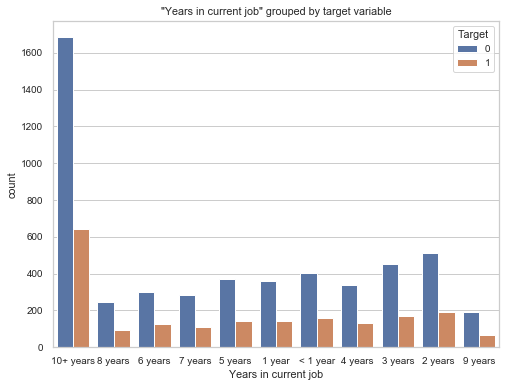

In [1083]:
plt.figure(figsize=(8, 6))

sns.countplot(x="Years in current job", hue=TARGET_NAME, data=train_df)
plt.title('\"Years in current job\" grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

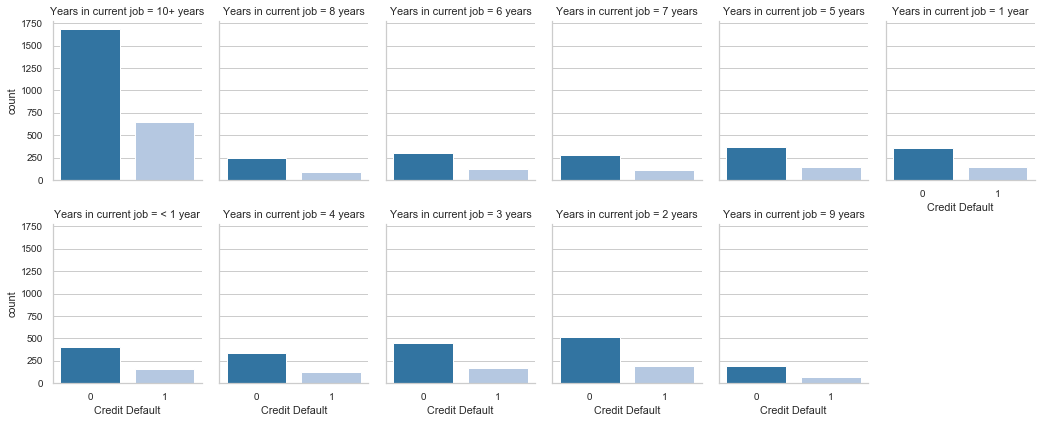

In [1084]:
# Сколько людей, в группах по стажу работы, не возвращает кредит

g = sns.catplot("Credit Default", col="Years in current job", col_wrap=6,
                data=train_df,
                kind="count", height=3, aspect=.8, 
                palette='tab20')

plt.show()

#### Bankruptcies

In [1085]:
train_df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

#### Current Loan Amount, Maximum Open Credit

Text(0.5, 1.0, 'Current Loan Amount')

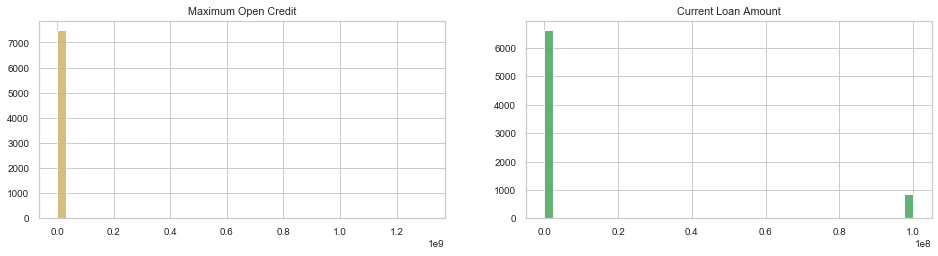

In [1086]:
fig = plt.figure(figsize = (16, 8))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)


ax1.hist(train_df['Maximum Open Credit'], bins=40, color='y', alpha=0.9)
ax1.set_title('Maximum Open Credit')

ax2.hist(train_df['Current Loan Amount'], bins=40, color='g', alpha=0.9)
ax2.set_title('Current Loan Amount')

In [1087]:
print(train_df['Current Loan Amount'].nunique(), ' уникальных  значений Current Loan Amount в обучающей выборке')
print(test_df['Current Loan Amount'].nunique(), ' уникальных  значений Current Loan Amount в тестовой выборке')
print('*******')

condition_1 = (train_df['Current Loan Amount'] == 99999999)
condition_2 = (test_df['Current Loan Amount'] == 99999999)
print(condition_1.sum(), ' значений Current Loan Amount в обучающей выборке равно 99999999')
print(condition_2.sum(), ' значений Current Loan Amount в тестовой выборке равно 99999999')
print('*******')

condition_3 = (train_df['Maximum Open Credit'] > 5000000)
condition_4 = (test_df['Maximum Open Credit'] > 5000000)
print(condition_3.sum(), ' значений Maximum Open Credit в обучающей выборке более 5 млн')
print(condition_4.sum(), ' значений Maximum Open Credit в тестовой выборке более 5 млн')

5386  уникальных  значений Current Loan Amount в обучающей выборке
2026  уникальных  значений Current Loan Amount в тестовой выборке
*******
870  значений Current Loan Amount в обучающей выборке равно 99999999
297  значений Current Loan Amount в тестовой выборке равно 99999999
*******
52  значений Maximum Open Credit в обучающей выборке более 5 млн
17  значений Maximum Open Credit в тестовой выборке более 5 млн


#### Current Credit Balance, Monthly Debt

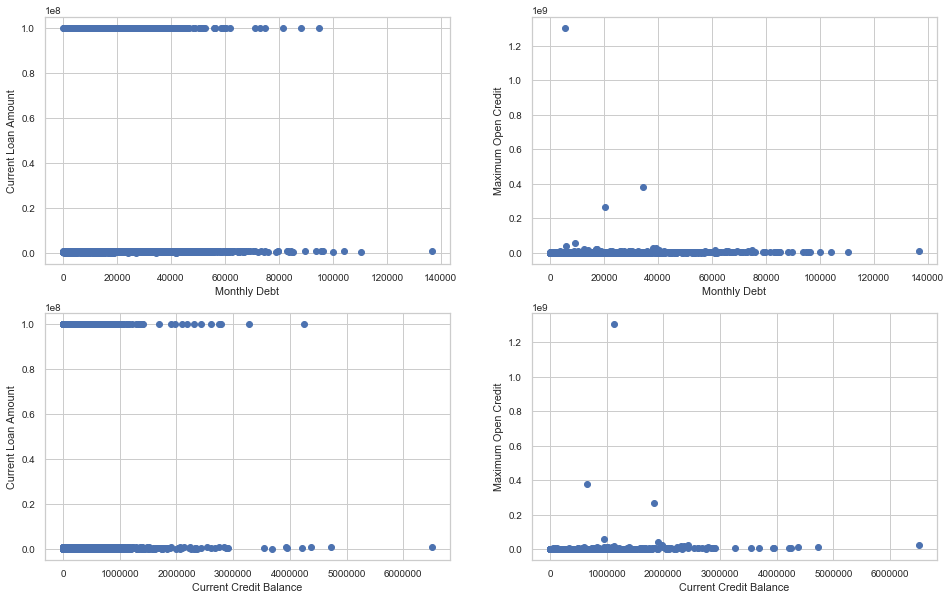

In [1088]:
fig = plt.figure(figsize = (16, 10))

ax1 = fig.add_subplot(221)
plt.scatter(train_df['Monthly Debt'], train_df['Current Loan Amount']);
plt.xlabel('Monthly Debt')
plt.ylabel('Current Loan Amount')

ax2 = fig.add_subplot(222)
plt.scatter(train_df['Monthly Debt'], train_df['Maximum Open Credit']);
plt.xlabel('Monthly Debt')
plt.ylabel('Maximum Open Credit')

ax3 = fig.add_subplot(223)
plt.scatter(train_df['Current Credit Balance'], train_df['Current Loan Amount']);
plt.xlabel('Current Credit Balance')
plt.ylabel('Current Loan Amount')

ax4 = fig.add_subplot(224)
plt.scatter(train_df['Current Credit Balance'], train_df['Maximum Open Credit']);
plt.xlabel('Current Credit Balance')
plt.ylabel('Maximum Open Credit')


plt.show()

In [1089]:
print(train_df['Current Credit Balance'].nunique(), ' уникальных  значений Current Credit Balance в обучающей выборке')
print(test_df['Current Credit Balance'].nunique(), ' уникальных  значений Current Credit Balance в тестовой выборке')
print('*******')

condition_5 = (train_df['Current Credit Balance'] > 3000000)
condition_6 = (test_df['Current Credit Balance'] > 3000000)
print(condition_5.sum(), ' значений Current Credit Balance в обучающей выборке более 3 млн')
print(condition_6.sum(), ' значений Current Credit Balance в тестовой выборке более 3 млн')
print('*******')

print(train_df['Monthly Debt'].nunique(), ' уникальных  значений Monthly Debt в обучающей выборке')
print(test_df['Monthly Debt'].nunique(), ' уникальных  значений Monthly Debt в тестовой выборке')
print('*******')

condition_7 = (train_df['Monthly Debt'] > 120000)
condition_8 = (test_df['Monthly Debt'] > 120000)
print(condition_7.sum(), ' значений Monthly Debt в обучающей выборке более 120000')
print(condition_8.sum(), ' значений Monthly Debt в тестовой выборке более 120000')

6592  уникальных  значений Current Credit Balance в обучающей выборке
2385  уникальных  значений Current Credit Balance в тестовой выборке
*******
10  значений Current Credit Balance в обучающей выборке более 3 млн
13  значений Current Credit Balance в тестовой выборке более 3 млн
*******
6716  уникальных  значений Monthly Debt в обучающей выборке
2416  уникальных  значений Monthly Debt в тестовой выборке
*******
1  значений Monthly Debt в обучающей выборке более 120000
0  значений Monthly Debt в тестовой выборке более 120000


Text(0.5, 1.0, 'Monthly Debt')

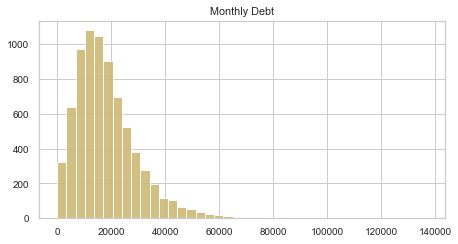

In [1090]:
fig = plt.figure(figsize = (16, 8))

ax1 = fig.add_subplot(221)


ax1.hist(train_df['Monthly Debt'], bins=40, color='y', alpha=0.9)
ax1.set_title('Monthly Debt')

#### Annual Income

In [1091]:
print(train_df['Annual Income'].nunique(), ' уникальных  значений Annual Income в обучающей выборке')
print(test_df['Annual Income'].nunique(), ' уникальных  значений Annual Income в тестовой выборке')

5478  уникальных  значений Annual Income в обучающей выборке
1929  уникальных  значений Annual Income в тестовой выборке


#### Number of Open Accounts

In [1092]:
train_df['Number of Open Accounts'].sort_values().unique()

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
       28., 29., 30., 31., 32., 33., 34., 35., 37., 38., 41., 42., 43.])

#### Months since last delinquent

In [1093]:
train_df['Months since last delinquent'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  86.,  91.,  92.,
       118.,  nan])

#### Years of Credit History

In [1094]:
print(train_df['Years of Credit History'].nunique(), ' уникальных  значений Years of Credit History в обучающей выборке')
print(test_df['Years of Credit History'].nunique(), ' уникальных  значений Years of Credit History в тестовой выборке')

408  уникальных  значений Years of Credit History в обучающей выборке
345  уникальных  значений Years of Credit History в тестовой выборке


#### Credit Score

In [1095]:
train_df['Credit Score'].sort_values().unique()

array([ 585.,  586.,  588.,  589.,  590.,  591.,  593.,  594.,  597.,
        598.,  599.,  601.,  602.,  604.,  606.,  607.,  608.,  609.,
        610.,  611.,  612.,  613.,  614.,  615.,  616.,  617.,  618.,
        619.,  620.,  621.,  622.,  624.,  625.,  626.,  627.,  628.,
        629.,  630.,  631.,  632.,  633.,  634.,  635.,  636.,  637.,
        638.,  639.,  640.,  642.,  643.,  644.,  645.,  646.,  647.,
        648.,  649.,  650.,  651.,  652.,  653.,  654.,  655.,  656.,
        657.,  658.,  659.,  660.,  661.,  662.,  663.,  664.,  665.,
        666.,  667.,  668.,  669.,  670.,  671.,  672.,  673.,  674.,
        675.,  676.,  677.,  678.,  679.,  680.,  681.,  682.,  683.,
        684.,  685.,  686.,  687.,  688.,  689.,  690.,  691.,  692.,
        693.,  694.,  695.,  696.,  697.,  698.,  699.,  700.,  701.,
        702.,  703.,  704.,  705.,  706.,  707.,  708.,  709.,  710.,
        711.,  712.,  713.,  714.,  715.,  716.,  717.,  718.,  719.,
        720.,  721.,

In [1096]:
condition_9 = (train_df['Annual Income'].isna() & train_df['Credit Score'].isna())
condition_10 = (test_df['Annual Income'].isna() & test_df['Credit Score'].isna())
print(condition_9.sum(), ' пропусков значений Annual Income и Credit Score в обучающей выборке')
print(condition_10.sum(), ' пропусков значений Annual Income и Credit Score в тестовой выборке')

1557  пропусков значений Annual Income и Credit Score в обучающей выборке
513  пропусков значений Annual Income и Credit Score в тестовой выборке


In [1097]:
print((train_df['Credit Score'] > 999).sum(), ' значений: кредитный рейтинг более 999')

400  значений: кредитный рейтинг более 999


**Наблюдения**:

*Number of Open Accounts* - на основании признака  можно создать новый признак с меньшим количеством категорий.

*Years of Credit History* - на основании признака  можно создать новый признак с меньшим количеством категорий.

*Months since last delinquent* - пропуски в признаке  вероятно свидетельствуют, что клиент не допускал просрочки. Тогда NaN является показателем отсутствия просрочек. Поменяем NaN на 0 и добавим новый бинарный признак задолженость есть/нет (1/0).

*Credit Score* - в признаке есть необычные высокие значения. Создадим новый признак с корректировкой выбросов.

*Annual Income* - значения этого признака пропущены в тех же случаях, когда пропущены значения признака Credit Score. Наличие/отсутствие данных о годовом доходе, кредитном рейтинге является важным фактором для принятия решения о надежности клиента. Нужно создать новый бинарный признак с пометкой об отсутствии/наличии данных о доходе. В самом признаке 'Annual Income' пропуски заменим на медианные значения.

### Класс с обработкой данных

#### Заполнение пропусков регрессией

- Annual Income
- Credit Score

Сначала заполняем в этих признаках пропуски медианой (наблюдения с пропусками помечаем отдельным признаком). Далее делаем для них категориальные признаки. При обучении модели отдаем только наблюдения, в которых не было пропусков, обучаем. После чего, выбираем помеченные наблюдения, как пропуски, и заполняем значения на основе предсказаний модели.

class Data:

    def __init__(self):
        
        self.medians = None
        self.model_regr_CrSc = None
        self.model_regr_AnIn = None
        
    def fit(self, df):
        self.medians = df[['Annual Income', 'Credit Score']].median()
        
    def fit_regr_Credit_Score(self, df):
        """Создание регрессии по Credit Score, обучение модели"""
        
        df_regr = df.copy()
        df_regr = df_regr[df_regr['Credit_Score_isnan'] == 0]
        df_regr = df_regr.drop(['Credit Default', 'Credit_Score_isnan'], axis=1)
        target_name_regr = 'Credit Score'
        feature_names_regr = df_regr.columns.drop(target_name_regr).tolist()
        feature_names_cat_regr = df_regr.select_dtypes(include=['int64', 'object']).columns.tolist()
        
        Xc = df_regr[feature_names_regr]
        yc = df_regr[target_name_regr]

        Xc_train, Xc_test, yc_train, yc_test = train_test_split(
            Xc,
            yc,
            shuffle=True,
            test_size=0.3,
            random_state=42
        )
        
        train_pool = Pool(Xc_train, yc_train, cat_features=feature_names_cat_regr)
        test_pool = Pool(Xc_test, yc_test, cat_features=feature_names_cat_regr)
        
        self.model_regr_CrSc = CatBoostRegressor(
            eval_metric='R2',
            silent=True,
            one_hot_max_size=20,
            early_stopping_rounds=40,
            boosting_type='Ordered',
            allow_writing_files=False,
            depth=4,
            iterations=400,
            learning_rate=0.03,
            l2_leaf_reg=2
        )

        self.model_regr_CrSc.fit(
            Pool(Xc_train, yc_train, cat_features=feature_names_cat_regr),
            eval_set=Pool(Xc_test, yc_test, cat_features=feature_names_cat_regr)
        )

        print(f'Credit Score R2: {self.model_regr_CrSc.get_best_score()}')
        del df_regr
        
    def fit_regr_Annual_Income(self, df):
        """Создание регрессии по Annual Income, обучение модели"""
        
        df_regr = df.copy()
        df_regr = df_regr[df_regr['Annual_Income_isnan'] == 0]
        df_regr = df_regr.drop(['Credit Default', 'Annual_Income_isnan'], axis=1)
        target_name_regr = 'Annual Income'
        feature_names_regr = df_regr.columns.drop(target_name_regr).tolist()
        feature_names_cat_regr = df_regr.select_dtypes(include=['int64', 'object']).columns.tolist()
        
        Xc = df_regr[feature_names_regr]
        yc = df_regr[target_name_regr]

        Xc_train, Xc_test, yc_train, yc_test = train_test_split(
            Xc,
            yc,
            shuffle=True,
            test_size=0.3,
            random_state=42
        )
        
        train_pool = Pool(Xc_train, yc_train, cat_features=feature_names_cat_regr)
        test_pool = Pool(Xc_test, yc_test, cat_features=feature_names_cat_regr)
        
        self.model_regr_AnIn = CatBoostRegressor(
            eval_metric='R2',
            silent=True,
            one_hot_max_size=20,
            early_stopping_rounds=40,
            boosting_type='Ordered',
            allow_writing_files=False,
            depth=6,
            iterations=900,
            learning_rate=0.5,
            l2_leaf_reg=3.5
        )

        self.model_regr_AnIn.fit(
            Pool(Xc_train, yc_train, cat_features=feature_names_cat_regr),
            eval_set=Pool(Xc_test, yc_test, cat_features=feature_names_cat_regr)
        )
        
        print(f'Annual Income R2: {self.model_regr_AnIn.get_best_score()}')
        del df_regr

    def apply_regr_Credit_Score(self, df):
        """Заполнение пропусков Credit Score"""
        
        cond = (df['Credit_Score_isnan'] == 1)
        Xc = df[cond].drop(['Credit Score', 'Credit Default', 'Credit_Score_isnan'], axis=1, errors='ignore')
        df.loc[cond, 'Credit Score'] = self.model_regr_CrSc.predict(Xc)
        df = df.drop(['Credit_Score_isnan', 'Credit_Score_cat'], axis=1)
        
        return df

    def apply_regr_Annual_Income(self, df):
        """Заполнение пропусков Annual Income"""
        
        cond = (df['Annual_Income_isnan'] == 1)
        Xc = df[cond].drop(['Annual Income', 'Credit Default', 'Annual_Income_isnan'], axis=1, errors='ignore')
        df.loc[cond, 'Annual Income'] = self.model_regr_AnIn.predict(Xc)
        df = df.drop(['Annual_Income_isnan', 'Annual_Income_cat'], axis=1)
        return df
    
    def transform(self, df):
        
        # 'Delinquent_cat' - категория наличия/отсутствия сведений и просрочке
#        df['Delinquent_cat'] = 1
#        df.loc[df['Months since last delinquent'].isna(), 'Delinquent_cat'] = 0        
        
        # 'Annual_Income_Unknown' - категория наличия/отсутствия информации о годовом доходе
#        df['Annual_Income_Unknown'] = 0
#        df.loc[df['Annual Income'].isna(), 'Annual_Income_Unknown'] = 1
        
        # 'Credit_Score_Unknown' - категория наличия/отсутствия кредитного рейтинга
#        df['Credit_Score_Unknown'] = 0
#        df.loc[df['Credit Score'].isnull(), 'Credit_Score_Unknown'] = 1

        # 'Credit_Score_Net' - признак, в котором странные значения 'Credit Score' уменьшены в 10 раз
#        df['Credit_Score_Net'] = df['Credit Score']
        df.loc[(df['Credit Score'] <= 999), 'Credit_Score_Net'] = df['Credit Score']
        df.loc[(df['Credit Score'] > 999), 'Credit_Score_Net'] = df['Credit Score']/10
        
        # пропуски
        df['Years in current job'].fillna('nan', inplace=True)
        df['Months since last delinquent'].fillna(0, inplace=True)
        df['Bankruptcies'].fillna(0, inplace=True)

        # заполнение Annual Income регрессией
        df['Annual_Income_isnan'] = 0
        df.loc[df['Annual Income'].isna(), 'Annual_Income_isnan'] = 1
        df['Annual Income'].fillna(self.medians['Annual Income'], inplace=True)
        
        # заполнение Credit Score регрессией
        df['Credit_Score_isnan'] = 0
        df.loc[df['Credit Score'].isna(), 'Credit_Score_isnan'] = 1
        df['Credit Score'].fillna(self.medians['Credit Score'], inplace=True)
        
        return df
    
    def features(self, df):
        
        # признак подозрительных наблдений
        df = self.feature_isSusp(df)
        
        # признак с кредитным рейтингом
        # используется при регрессии, далее удаляется
        df = self.credit_score_to_cat(df)
        
        # признак с текущей суммой кредита, разбитой на категории
        df = self.current_loan_amount_to_cat(df)
        
        # признак с годовым доходом, разбитым на категории
        # используется при регрессии, далее удаляется
        df = self.annual_income_to_cat(df)
        
        columns_to_int = ['Tax Liens', 'Bankruptcies', 'Number of Credit Problems']
        df[columns_to_int] = df[columns_to_int].astype(int)
        
        return df
    
    @staticmethod
    def credit_score_to_cat(df):
        """Создание признака Credit_Score_cat"""
        
        df['Credit_Score_cat'] = np.nan
        
        df.loc[df['Credit Score'] < 600, 'Credit_Score_cat'] = 1
        df.loc[(df['Credit Score'] >= 600) & (df['Credit Score'] < 650), 'Credit_Score_cat'] = 2
        df.loc[(df['Credit Score'] >= 650) & (df['Credit Score'] < 700), 'Credit_Score_cat'] = 3
        df.loc[(df['Credit Score'] >= 700) & (df['Credit Score'] < 725), 'Credit_Score_cat'] = 4
        df.loc[(df['Credit Score'] >= 725) & (df['Credit Score'] < 735), 'Credit_Score_cat'] = 5
        df.loc[(df['Credit Score'] >= 735) & (df['Credit Score'] < 745), 'Credit_Score_cat'] = 6
        df.loc[(df['Credit Score'] >= 745) & (df['Credit Score'] < 755), 'Credit_Score_cat'] = 7
        df.loc[df['Credit Score'] >= 755, 'Credit_Score_cat'] = 8
        
        df['Credit_Score_cat'] = df['Credit_Score_cat'].astype(int)
        
        return df
    
    @staticmethod
    def current_loan_amount_to_cat(df):
        """Создание признака Current_Loan_Amount_cat"""
        
        df['Current_Loan_Amount_cat'] = np.nan
        
        df.loc[df['Current Loan Amount'] < 100000, 'Current_Loan_Amount_cat'] = 1
        df.loc[(df['Current Loan Amount'] >= 100000) & (df['Current Loan Amount'] < 150000), 'Current_Loan_Amount_cat'] = 2
        df.loc[(df['Current Loan Amount'] >= 150000) & (df['Current Loan Amount'] < 250000), 'Current_Loan_Amount_cat'] = 3
        df.loc[(df['Current Loan Amount'] >= 250000) & (df['Current Loan Amount'] < 300000), 'Current_Loan_Amount_cat'] = 4
        df.loc[(df['Current Loan Amount'] >= 300000) & (df['Current Loan Amount'] < 325000), 'Current_Loan_Amount_cat'] = 5
        df.loc[(df['Current Loan Amount'] >= 325000) & (df['Current Loan Amount'] < 350000), 'Current_Loan_Amount_cat'] = 6
        df.loc[(df['Current Loan Amount'] >= 350000) & (df['Current Loan Amount'] < 400000), 'Current_Loan_Amount_cat'] = 7
        df.loc[(df['Current Loan Amount'] >= 400000) & (df['Current Loan Amount'] < 450000), 'Current_Loan_Amount_cat'] = 8
        df.loc[(df['Current Loan Amount'] >= 450000) & (df['Current Loan Amount'] < 500000), 'Current_Loan_Amount_cat'] = 9
        df.loc[df['Current Loan Amount'] >= 500000, 'Current_Loan_Amount_cat'] = 10
        
        df['Current_Loan_Amount_cat'] = df['Current_Loan_Amount_cat'].astype(int)
        
        return df
    
    @staticmethod
    def annual_income_to_cat(df):
        """Создание признака Annual_Income_cat"""
        
        df['Annual_Income_cat'] = np.nan
        
        df.loc[df['Annual Income'] < 500000, 'Annual_Income_cat'] = 1
        df.loc[(df['Annual Income'] >= 500000) & (df['Annual Income'] < 750000), 'Annual_Income_cat'] = 2
        df.loc[(df['Annual Income'] >= 750000) & (df['Annual Income'] < 1000000), 'Annual_Income_cat'] = 3
        df.loc[(df['Annual Income'] >= 1000000) & (df['Annual Income'] < 1125000), 'Annual_Income_cat'] = 4
        df.loc[(df['Annual Income'] >= 1125000) & (df['Annual Income'] < 1250000), 'Annual_Income_cat'] = 5
        df.loc[(df['Annual Income'] >= 1250000) & (df['Annual Income'] < 1500000), 'Annual_Income_cat'] = 6
        df.loc[(df['Annual Income'] >= 1500000) & (df['Annual Income'] < 1750000), 'Annual_Income_cat'] = 7
        df.loc[(df['Annual Income'] >= 1750000) & (df['Annual Income'] < 2000000), 'Annual_Income_cat'] = 8
        df.loc[(df['Annual Income'] >= 2000000) & (df['Annual Income'] < 2500000), 'Annual_Income_cat'] = 9
        df.loc[df['Annual Income'] >= 2500000, 'Annual_Income_cat'] = 10
        
        df['Annual_Income_cat'] = df['Annual_Income_cat'].astype(int)
        
        return df
    
    @staticmethod
    def feature_isSusp(df):
        """Признак подозрительных наблюдений"""
        
        df['Credit_Score_Strange'] = 0
        df.loc[df['Years of Credit History'] > 55, 'Credit_Score_Strange'] = 1
        df.loc[df['Credit Score'] > 1000, 'Credit_Score_Strange'] = 1
       
        # 'Current_Loan_Amount_Strange' - признак наличия странных значений в 'Current Loan Amount'
        df['Current_Loan_Amount_Strange'] = 0
        df.loc[(df['Current Loan Amount'] == 99999999), 'Current_Loan_Amount_Strange'] = 1
        
        # 'Maximum_Open_Credit_Strange' - признак наличия странных значений в 'Maximum Open Credit'
        df['Maximum_Open_Credit_Strange'] = 0
        df.loc[(df['Maximum Open Credit'] > 5000000), 'Maximum_Open_Credit_Strange'] = 1
        
        # 'Current_Credit_Balance_Strange' - признак наличия странных значений в 'Current Credit Balance'
        df['Current_Credit_Balance_Strange'] = 0
        df.loc[(df['Current Credit Balance'] > 3000000), 'Current_Credit_Balance_Strange'] = 1
        
        # 'Monthly_Debt_Strange' - признак наличия странных значений в 'Monthly Debt'
        df['Monthly_Debt_Strange'] = 0
        df.loc[(df['Monthly Debt'] > 120000), 'Monthly_Debt_Strange'] = 1
           
        return df

    @staticmethod
    def number_of_open_accounts_to_cat(df):
        """Создание признака Number_of_OpenAccounts_Сat"""
        
        df['Number_of_OpenAccounts_Сat'] = np.nan
        
        df.loc[df['Number of Open Accounts'] <= 5, 'Number_of_OpenAccounts_Сat'] = 1
        df.loc[(df['Number of Open Accounts'] > 5) & (df['Number of Open Accounts'] <= 7), 'Number_of_OpenAccounts_Сat'] = 2
        df.loc[(df['Number of Open Accounts'] > 7) & (df['Number of Open Accounts'] <= 10), 'Number_of_OpenAccounts_Сat'] = 3
        df.loc[(df['Number of Open Accounts'] > 10) & (df['Number of Open Accounts'] <= 14), 'Number_of_OpenAccounts_Сat'] = 4
        df.loc[(df['Number of Open Accounts'] > 14) & (df['Number of Open Accounts'] <= 19), 'Number_of_OpenAccounts_Сat'] = 5
        df.loc[df['Number of Open Accounts'] > 19, 'Number_of_OpenAccounts_Сat'] = 6
        
        df['Number_of_OpenAccounts_Сat'] = df['Number_of_OpenAccounts_Сat'].astype(int)
                
        return df
    
    @staticmethod
    def years_of_credit_history_to_cat(df):
        """Создание признака Years_of_Credit_History_Сat - категория количества лет кредитной истории"""
        
        df['Years_of_Credit_History_Сat'] = np.nan
        
        df.loc[df['Years of Credit History'] <= 9, 'Years_of_Credit_History_Сat'] = 1
        df.loc[(df['Years of Credit History'] > 9) & (df['Years of Credit History'] <= 13), 'Years_of_Credit_History_Сat'] = 2
        df.loc[(df['Years of Credit History'] > 13) & (df['Years of Credit History'] <= 17), 'Years_of_Credit_History_Сat'] = 3
        df.loc[(df['Years of Credit History'] > 17) & (df['Years of Credit History'] <= 23), 'Years_of_Credit_History_Сat'] = 4
        df.loc[(df['Years of Credit History'] > 23) & (df['Years of Credit History'] <= 30), 'Years_of_Credit_History_Сat'] = 5
        df.loc[df['Years of Credit History'] > 30, 'Years_of_Credit_History_Сat'] = 6
        
        df['Years_of_Credit_History_Сat'] = df['Years_of_Credit_History_Сat'].astype(int)
        
        return df

In [1098]:
class Data:

    def __init__(self):
        
        self.medians = None
        self.model_regr_AnIn = None
        
    def fit(self, df):
        self.medians = df[['Annual Income']].median()
        
         
    def fit_regr_Annual_Income(self, df):
        """Создание регрессии по Annual Income, обучение модели"""
        
        df_regr = df.copy()
        df_regr = df_regr[df_regr['Annual_Income_isnan'] == 0]
        df_regr = df_regr.drop(['Credit Default', 'Annual_Income_isnan'], axis=1)
        target_name_regr = 'Annual Income'
        feature_names_regr = df_regr.columns.drop(target_name_regr).tolist()
        feature_names_cat_regr = df_regr.select_dtypes(include=['int64', 'object']).columns.tolist()
        
        Xc = df_regr[feature_names_regr]
        yc = df_regr[target_name_regr]

        Xc_train, Xc_test, yc_train, yc_test = train_test_split(
            Xc,
            yc,
            shuffle=True,
            test_size=0.3,
            random_state=42
        )
        
        train_pool = Pool(Xc_train, yc_train, cat_features=feature_names_cat_regr)
        test_pool = Pool(Xc_test, yc_test, cat_features=feature_names_cat_regr)
        
        self.model_regr_AnIn = CatBoostRegressor(
            eval_metric='R2',
            silent=True,
            one_hot_max_size=20,
            early_stopping_rounds=40,
            boosting_type='Ordered',
            allow_writing_files=False,
            depth=6,
            iterations=900,
            learning_rate=0.5,
            l2_leaf_reg=3.5
        )

        self.model_regr_AnIn.fit(
            Pool(Xc_train, yc_train, cat_features=feature_names_cat_regr),
            eval_set=Pool(Xc_test, yc_test, cat_features=feature_names_cat_regr)
        )
        
        print(f'Annual Income R2: {self.model_regr_AnIn.get_best_score()}')
        del df_regr


    def apply_regr_Annual_Income(self, df):
        """Заполнение пропусков Annual Income"""
        
        cond = (df['Annual_Income_isnan'] == 1)
        Xc = df[cond].drop(['Annual Income', 'Credit Default', 'Annual_Income_isnan'], axis=1, errors='ignore')
        df.loc[cond, 'Annual Income'] = self.model_regr_AnIn.predict(Xc)
        df = df.drop(['Annual_Income_isnan', 'Annual_Income_cat'], axis=1)
        return df
    
    def transform(self, df):
        
        # 'Credit_Score_Net' - признак, в котором странные значения 'Credit Score' уменьшены в 10 раз
#        df['Credit_Score_Net'] = df['Credit Score']
        df.loc[(df['Credit Score'] <= 999), 'Credit_Score_Net'] = df['Credit Score']
        df.loc[(df['Credit Score'] > 999), 'Credit_Score_Net'] = df['Credit Score']/10
        
        # пропуски
        df['Years in current job'].fillna('nan', inplace=True)
        df['Months since last delinquent'].fillna(0, inplace=True)
        df['Bankruptcies'].fillna(0, inplace=True)

        # заполнение Annual Income регрессией
        df['Annual_Income_isnan'] = 0
        df.loc[df['Annual Income'].isna(), 'Annual_Income_isnan'] = 1
        df['Annual Income'].fillna(self.medians['Annual Income'], inplace=True)
       
        return df
    
    def features(self, df):
        
        # признак подозрительных наблдений
        df = self.feature_isSusp(df)
        
        # признак с текущей суммой кредита, разбитой на категории
        df = self.current_loan_amount_to_cat(df)
        
        # признак с годовым доходом, разбитым на категории
        # используется при регрессии, далее удаляется
        df = self.annual_income_to_cat(df)
        
        columns_to_int = ['Tax Liens', 'Bankruptcies', 'Number of Credit Problems']
        df[columns_to_int] = df[columns_to_int].astype(int)
        
        return df
    
    
    @staticmethod
    def current_loan_amount_to_cat(df):
        """Создание признака Current_Loan_Amount_cat"""
        
        df['Current_Loan_Amount_cat'] = np.nan
        
        df.loc[df['Current Loan Amount'] < 100000, 'Current_Loan_Amount_cat'] = 1
        df.loc[(df['Current Loan Amount'] >= 100000) & (df['Current Loan Amount'] < 150000), 'Current_Loan_Amount_cat'] = 2
        df.loc[(df['Current Loan Amount'] >= 150000) & (df['Current Loan Amount'] < 250000), 'Current_Loan_Amount_cat'] = 3
        df.loc[(df['Current Loan Amount'] >= 250000) & (df['Current Loan Amount'] < 300000), 'Current_Loan_Amount_cat'] = 4
        df.loc[(df['Current Loan Amount'] >= 300000) & (df['Current Loan Amount'] < 325000), 'Current_Loan_Amount_cat'] = 5
        df.loc[(df['Current Loan Amount'] >= 325000) & (df['Current Loan Amount'] < 350000), 'Current_Loan_Amount_cat'] = 6
        df.loc[(df['Current Loan Amount'] >= 350000) & (df['Current Loan Amount'] < 400000), 'Current_Loan_Amount_cat'] = 7
        df.loc[(df['Current Loan Amount'] >= 400000) & (df['Current Loan Amount'] < 450000), 'Current_Loan_Amount_cat'] = 8
        df.loc[(df['Current Loan Amount'] >= 450000) & (df['Current Loan Amount'] < 500000), 'Current_Loan_Amount_cat'] = 9
        df.loc[df['Current Loan Amount'] >= 500000, 'Current_Loan_Amount_cat'] = 10
        
        df['Current_Loan_Amount_cat'] = df['Current_Loan_Amount_cat'].astype(int)
        
        return df
    
    @staticmethod
    def annual_income_to_cat(df):
        """Создание признака Annual_Income_cat"""
        
        df['Annual_Income_cat'] = np.nan
        
        df.loc[df['Annual Income'] < 500000, 'Annual_Income_cat'] = 1
        df.loc[(df['Annual Income'] >= 500000) & (df['Annual Income'] < 750000), 'Annual_Income_cat'] = 2
        df.loc[(df['Annual Income'] >= 750000) & (df['Annual Income'] < 1000000), 'Annual_Income_cat'] = 3
        df.loc[(df['Annual Income'] >= 1000000) & (df['Annual Income'] < 1125000), 'Annual_Income_cat'] = 4
        df.loc[(df['Annual Income'] >= 1125000) & (df['Annual Income'] < 1250000), 'Annual_Income_cat'] = 5
        df.loc[(df['Annual Income'] >= 1250000) & (df['Annual Income'] < 1500000), 'Annual_Income_cat'] = 6
        df.loc[(df['Annual Income'] >= 1500000) & (df['Annual Income'] < 1750000), 'Annual_Income_cat'] = 7
        df.loc[(df['Annual Income'] >= 1750000) & (df['Annual Income'] < 2000000), 'Annual_Income_cat'] = 8
        df.loc[(df['Annual Income'] >= 2000000) & (df['Annual Income'] < 2500000), 'Annual_Income_cat'] = 9
        df.loc[df['Annual Income'] >= 2500000, 'Annual_Income_cat'] = 10
        
        df['Annual_Income_cat'] = df['Annual_Income_cat'].astype(int)
        
        return df
    
    @staticmethod
    def feature_isSusp(df):
        """Признак подозрительных наблюдений"""
        
        df['Credit_Score_Strange'] = 0
        df.loc[df['Years of Credit History'] > 55, 'Credit_Score_Strange'] = 1
        df.loc[df['Credit Score'] > 1000, 'Credit_Score_Strange'] = 1
       
        # 'Current_Loan_Amount_Strange' - признак наличия странных значений в 'Current Loan Amount'
        df['Current_Loan_Amount_Strange'] = 0
        df.loc[(df['Current Loan Amount'] == 99999999), 'Current_Loan_Amount_Strange'] = 1
        
        # 'Maximum_Open_Credit_Strange' - признак наличия странных значений в 'Maximum Open Credit'
        df['Maximum_Open_Credit_Strange'] = 0
        df.loc[(df['Maximum Open Credit'] > 5000000), 'Maximum_Open_Credit_Strange'] = 1
        
        # 'Current_Credit_Balance_Strange' - признак наличия странных значений в 'Current Credit Balance'
        df['Current_Credit_Balance_Strange'] = 0
        df.loc[(df['Current Credit Balance'] > 3000000), 'Current_Credit_Balance_Strange'] = 1
        
        # 'Monthly_Debt_Strange' - признак наличия странных значений в 'Monthly Debt'
        df['Monthly_Debt_Strange'] = 0
        df.loc[(df['Monthly Debt'] > 120000), 'Monthly_Debt_Strange'] = 1
           
        return df

    @staticmethod
    def number_of_open_accounts_to_cat(df):
        """Создание признака Number_of_OpenAccounts_Сat"""
        
        df['Number_of_OpenAccounts_Сat'] = np.nan
        
        df.loc[df['Number of Open Accounts'] <= 5, 'Number_of_OpenAccounts_Сat'] = 1
        df.loc[(df['Number of Open Accounts'] > 5) & (df['Number of Open Accounts'] <= 7), 'Number_of_OpenAccounts_Сat'] = 2
        df.loc[(df['Number of Open Accounts'] > 7) & (df['Number of Open Accounts'] <= 10), 'Number_of_OpenAccounts_Сat'] = 3
        df.loc[(df['Number of Open Accounts'] > 10) & (df['Number of Open Accounts'] <= 14), 'Number_of_OpenAccounts_Сat'] = 4
        df.loc[(df['Number of Open Accounts'] > 14) & (df['Number of Open Accounts'] <= 19), 'Number_of_OpenAccounts_Сat'] = 5
        df.loc[df['Number of Open Accounts'] > 19, 'Number_of_OpenAccounts_Сat'] = 6
        
        df['Number_of_OpenAccounts_Сat'] = df['Number_of_OpenAccounts_Сat'].astype(int)
                
        return df
    
    @staticmethod
    def years_of_credit_history_to_cat(df):
        """Создание признака Years_of_Credit_History_Сat - категория количества лет кредитной истории"""
        
        df['Years_of_Credit_History_Сat'] = np.nan
        
        df.loc[df['Years of Credit History'] <= 9, 'Years_of_Credit_History_Сat'] = 1
        df.loc[(df['Years of Credit History'] > 9) & (df['Years of Credit History'] <= 13), 'Years_of_Credit_History_Сat'] = 2
        df.loc[(df['Years of Credit History'] > 13) & (df['Years of Credit History'] <= 17), 'Years_of_Credit_History_Сat'] = 3
        df.loc[(df['Years of Credit History'] > 17) & (df['Years of Credit History'] <= 23), 'Years_of_Credit_History_Сat'] = 4
        df.loc[(df['Years of Credit History'] > 23) & (df['Years of Credit History'] <= 30), 'Years_of_Credit_History_Сat'] = 5
        df.loc[df['Years of Credit History'] > 30, 'Years_of_Credit_History_Сat'] = 6
        
        df['Years_of_Credit_History_Сat'] = df['Years_of_Credit_History_Сat'].astype(int)
        
        return df

##### Инициализация класса

In [1099]:
df_train_base = pd.read_csv(TRAIN_DATASET_PATH)
df_valid_base = pd.read_csv(TEST_DATASET_PATH)

data_inst = Data()

# тренировочный датасет
data_inst.fit(df_train_base)
train_df = data_inst.transform(df_train_base)
train_df = data_inst.features(train_df)

# регрессия Annual Income
data_inst.fit_regr_Annual_Income(train_df)
train_df = data_inst.apply_regr_Annual_Income(train_df)

# создание новой категории
train_df = data_inst.number_of_open_accounts_to_cat(train_df)
train_df = data_inst.years_of_credit_history_to_cat(train_df)

# тестовый датасет
test_df = data_inst.transform(df_valid_base)
test_df = data_inst.features(test_df)
test_df = data_inst.apply_regr_Annual_Income(test_df)
test_df = data_inst.number_of_open_accounts_to_cat(test_df)
test_df = data_inst.years_of_credit_history_to_cat(test_df)

Annual Income R2: {'learn': {'R2': 0.9403813664643884, 'RMSE': 202705.47243353244}, 'validation': {'R2': 0.8366458973734412, 'RMSE': 355441.2488335436}}


### Обработка выбросов

In [1100]:
# В признаке Current Loan Amount значения равные 99999999 заменим на медианные значения.
train_df.loc[(train_df['Current Loan Amount'] == 99999999), 'Current Loan Amount'] = \
            train_df['Current Loan Amount'].median()
test_df.loc[(test_df['Current Loan Amount'] == 99999999), 'Current Loan Amount'] = \
            train_df['Current Loan Amount'].median()

# В признаке Maximum Open Credit значения более 5000000 заменим на медианные значения.
train_df.loc[(train_df['Maximum Open Credit'] > 5000000), 'Maximum Open Credit'] = \
            train_df['Maximum Open Credit'].median()
test_df.loc[(test_df['Maximum Open Credit'] > 5000000), 'Maximum Open Credit'] = \
            train_df['Maximum Open Credit'].median()

# В признаке Current Credit Balance значения более 3000000 заменим на медианные значения.
train_df.loc[(train_df['Current Credit Balance'] > 3000000), 'Current Credit Balance'] = \
            train_df['Current Credit Balance'].median()
test_df.loc[(test_df['Current Credit Balance'] > 3000000), 'Current Credit Balance'] = \
            train_df['Current Credit Balance'].median()

# В признаке Monthly Debt значения более 120000 заменим на медианные значения.
train_df.loc[(train_df['Monthly Debt'] > 120000), 'Monthly Debt'] = \
            train_df['Monthly Debt'].median()
test_df.loc[(test_df['Monthly Debt'] > 120000), 'Monthly Debt'] = \
            train_df['Monthly Debt'].median()

# В новом признаке 'Credit_Score_Net' заменим пропуски на медианные значения
train_df.loc[train_df['Credit_Score_Net'].isna(), 'Credit_Score_Net'] = train_df['Credit_Score_Net'].median()
test_df.loc[test_df['Credit_Score_Net'].isna(), 'Credit_Score_Net'] = train_df['Credit_Score_Net'].median()

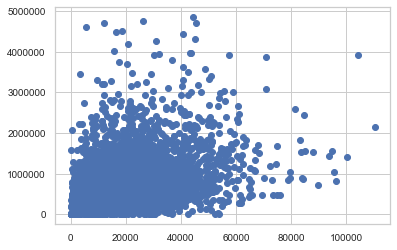

In [1102]:
plt.scatter(train_df['Monthly Debt'], train_df['Maximum Open Credit']);

Text(0.5, 1.0, 'Current Loan Amount')

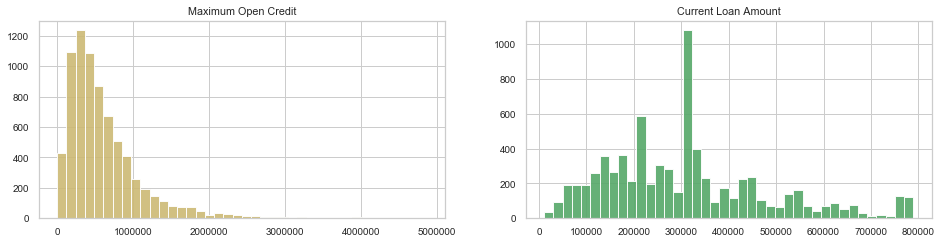

In [1103]:
fig = plt.figure(figsize = (16, 8))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)


ax1.hist(train_df['Maximum Open Credit'], bins=40, color='y', alpha=0.9)
ax1.set_title('Maximum Open Credit')

ax2.hist(train_df['Current Loan Amount'], bins=40, color='g', alpha=0.9)
ax2.set_title('Current Loan Amount')

**Number_of_Open_Accounts_Cat** - категория количества открытых счетов

**Years_of_Credit_History_Cat** - категория количества лет кредитной истории

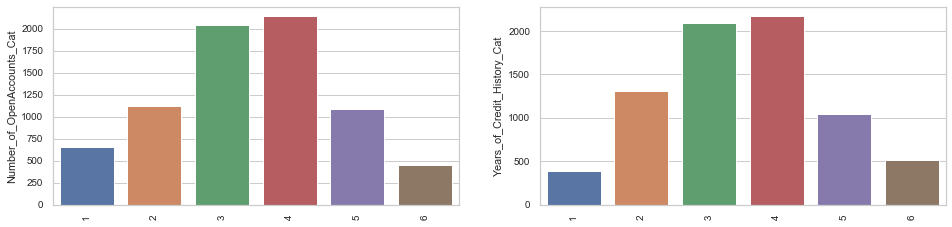

In [1104]:
sns.set(style="whitegrid", font_scale=0.9)

fig = plt.figure(figsize = (16, 8))

ax1 = fig.add_subplot(221)
sns.barplot(y=train_df['Number_of_OpenAccounts_Сat'].value_counts(), 
            x=train_df['Number_of_OpenAccounts_Сat'].value_counts().index,
           )
ax1.tick_params(axis='x', rotation=90);

ax2 = fig.add_subplot(222)
sns.barplot(y=train_df['Years_of_Credit_History_Сat'].value_counts(), 
            x=train_df['Years_of_Credit_History_Сat'].value_counts().index,
           )
ax2.tick_params(axis='x', rotation=90);

### Обработка категориальных признаков

In [1105]:
for cat_colname in train_df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
nan           371
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses 

#### Преобразование Term

In [1106]:
train_df['Term_binary'] = train_df['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(int)
test_df['Term_binary'] = test_df['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(int)

In [1107]:
train_df.select_dtypes(include='object').columns[0:]

Index(['Home Ownership', 'Years in current job', 'Purpose', 'Term'], dtype='object')

## Модель

#### Подключение библиотек и скриптов

In [1109]:
import pickle

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

In [1110]:
import warnings
warnings.filterwarnings('ignore')

In [1111]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [1112]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [1113]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)


    return df.sample(frac=1) 

#### Пути к директориям и файлам

In [1114]:
# output
MODELS_PATH = Path('./models/')
MODEL_FILE_PATH = MODELS_PATH / 'model.pkl'

SCALER_FILE_PATH = MODELS_PATH / 'scaler.pkl'

### Выделение групп признаков

In [1115]:
BASE_FEATURE_NAMES = base_df.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = train_df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

NUM_FEATURE_NAMES = train_df.select_dtypes(include='float64').columns.tolist()
CAT_FEATURE_NAMES = train_df.select_dtypes(include=['int64', 'object']).columns.drop(TARGET_NAME).tolist()

### Анализ целевой переменной

#### Корреляция признаков с целевой переменной

Text(0.5, 1.0, 'Correlation with target variable')

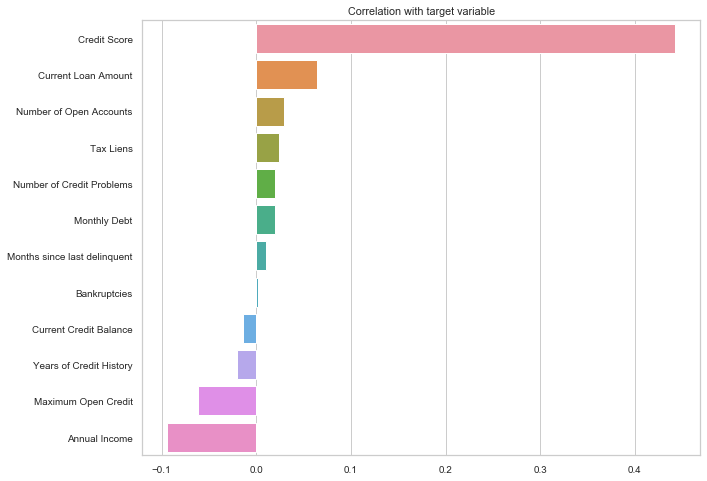

In [1116]:
# Корреляция базовых признаков с целевой переменной
corr_with_target = train_df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')

Text(0.5, 1.0, 'Correlation with target variable')

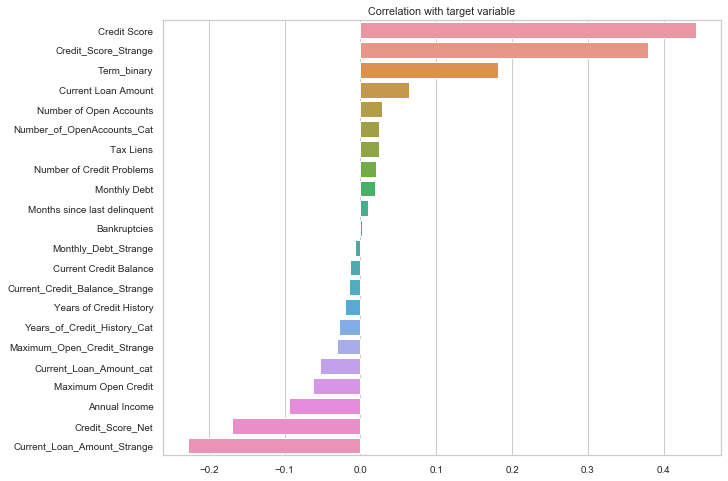

In [1117]:
# Корреляция базовых и новых признаков с целевой переменной
SELECTED_FEATURE_NAMES = BASE_FEATURE_NAMES + NEW_FEATURE_NAMES

corr_with_target = train_df[SELECTED_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')

#### Оценка признака "Credit Score" в разрезе целевой переменной

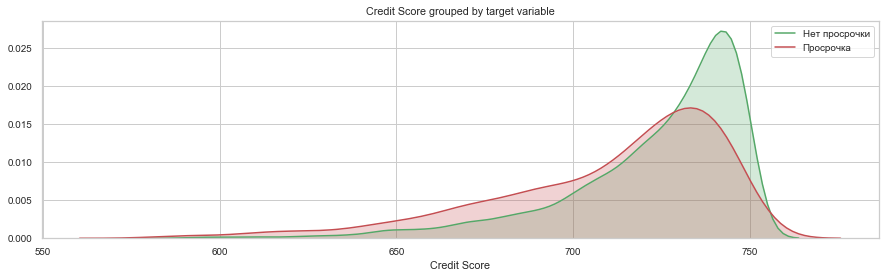

In [1118]:
credit_score_with_target = train_df[train_df['Credit Score'] < 1000][['Credit Score', TARGET_NAME]]
credit_score = credit_score_with_target['Credit Score']
credit_score_target_0 = credit_score[credit_score_with_target[TARGET_NAME] == 0]
credit_score_target_1 = credit_score[credit_score_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(15, 4))

sns.kdeplot(credit_score_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(credit_score_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Credit Score')
plt.title('Credit Score grouped by target variable')
plt.show()

**Наблюдение**

Похоже что две группы, полученные в результате разбиения признака "Credit score" по целевой переменной, имеют различные распределения, что может помочь при построение модели, т.к. это будет означать, что между признаком "Credit Score" и целевой переменной, возможно, существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест) и его аналоги
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Что бы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет равенства средних значений.
Если вероятность того, что мат. ожидания в исходных группах равны, при данных выборках, будет менее 5%, то можно будет говорить о том, что скорее всего выборки имеют различные распределения.

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка*

In [1119]:
shapiro(credit_score)

(0.8480203151702881, 0.0)

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

*Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график*

((array([-3.66217536, -3.42845283, -3.29971701, ...,  3.29971701,
          3.42845283,  3.66217536]),
  array([585., 586., 588., ..., 751., 751., 751.])),
 (25.477712801146716, 720.7059354140357, 0.9209213578101845))

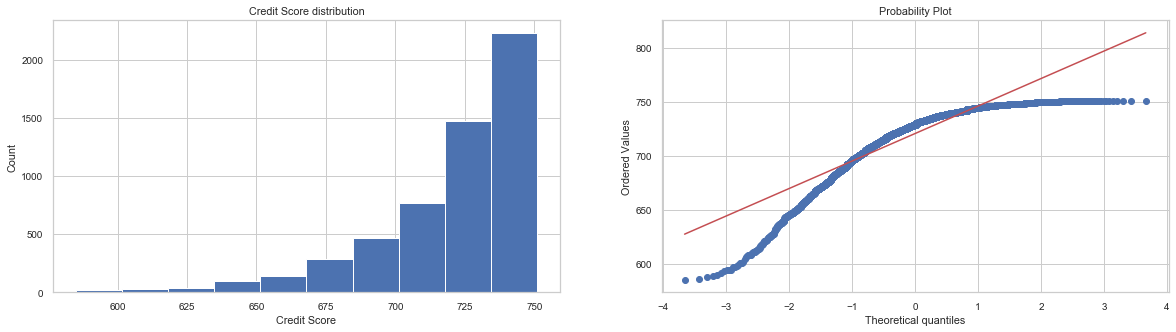

In [1120]:
plt.figure(figsize=(20, 5))

ax1 = plt.subplot(121)
ax1.set_xlabel('Credit Score')
ax1.set_ylabel('Count')
ax1.set_title('Credit Score distribution')
credit_score.hist()

ax2 = plt.subplot(122)
probplot(credit_score, dist='norm', plot=plt)

Визуальная оценка подтверждает показания критерия Шапиро-Уилка по поводу того, что закон распределения отличный от "нормального", в связи с чем, мы не сможем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака 'Credit Score' в группах с просроченным и непросроченным платежом в следующем месяце, но мы сможем воспользоваться его непараметрическим аналогом - критерием Манна-Уитни, который не требователен к закону распределения.

*Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни*

In [1121]:
mannwhitneyu(credit_score_target_0, credit_score_target_1)

MannwhitneyuResult(statistic=1872400.0, pvalue=5.690429274717866e-48)

Значение p-value меньше 0.05, следовательно гипотеза о равности математических ожиданий отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам. 

*Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их*

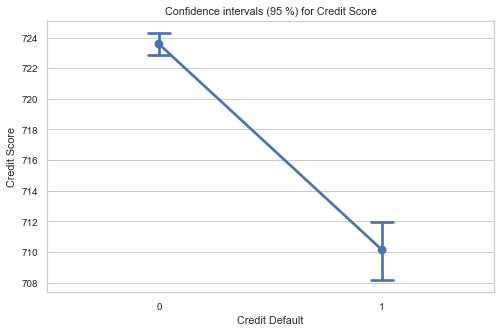

In [1122]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Credit Score', data=credit_score_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

#### Оценка признаков 'Credit_Score_Strange', 'Current_Loan_Amount_Strange', 'Term_binary' в разрезе целевой переменной

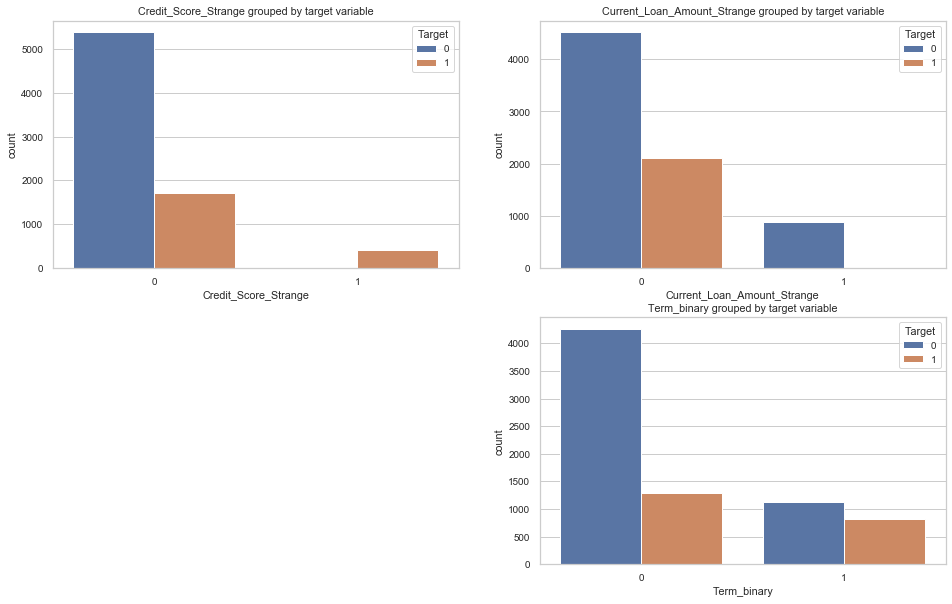

In [1123]:
fig = plt.figure(figsize = (16, 10))

ax1 = fig.add_subplot(221)
sns.countplot(x="Credit_Score_Strange", hue=TARGET_NAME, data=train_df)
ax1.set_title('Credit_Score_Strange grouped by target variable')
ax1.legend(title='Target', loc='upper right')

ax2 = fig.add_subplot(222)
sns.countplot(x="Current_Loan_Amount_Strange", hue=TARGET_NAME, data=train_df)
ax2.set_title('Current_Loan_Amount_Strange grouped by target variable')
ax2.legend(title='Target', loc='upper right')

ax3 = fig.add_subplot(224)
sns.countplot(x="Term_binary", hue=TARGET_NAME, data=train_df)
ax3.set_title('Term_binary grouped by target variable')
ax3.legend(title='Target', loc='upper right')

plt.show()

#### Оценка признака "Annual Income" в разрезе целевой переменной

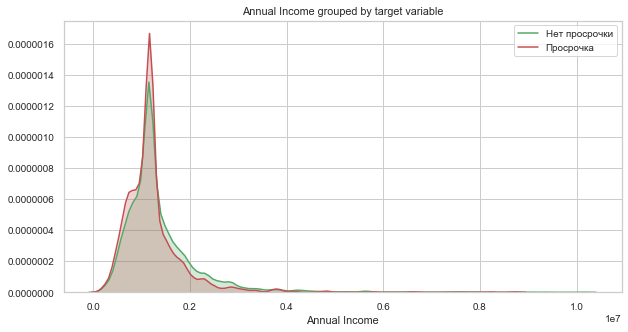

In [1124]:
annual_income_with_target = train_df[['Annual Income', TARGET_NAME]]
annual_income = annual_income_with_target['Annual Income']
annual_income_target_0 = annual_income[annual_income_with_target[TARGET_NAME] == 0]
annual_income_target_1 = annual_income[annual_income_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(annual_income_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(annual_income_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Annual Income')
plt.title('Annual Income grouped by target variable')
plt.show()

**Наблюдение**

Похоже что две группы, полученные в результате разбиения признака "Annual Income" по целевой переменной, имеют различные распределения, что может помочь при построение модели, т.к. это будет означать, что между признаком "Annual Income" и целевой переменной, возможно, существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест) и его аналоги
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Что бы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет равенства средних значений.
Если вероятность того, что мат. ожидания в исходных группах равны, при данных выборках, будет менее 5%, то можно будет говорить о том, что скорее всего выборки имеют различные распределения.

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка*

In [1125]:
shapiro(annual_income)

(0.7339446544647217, 0.0)

((array([-3.73889526, -3.50968086, -3.3836472 , ...,  3.3836472 ,
          3.50968086,  3.73889526]),
  array([  164597.,   175845.,   177251., ...,  8923844.,  9338880.,
         10149344.])),
 (648792.867202853, 1324519.0403494467, 0.8564153147618502))

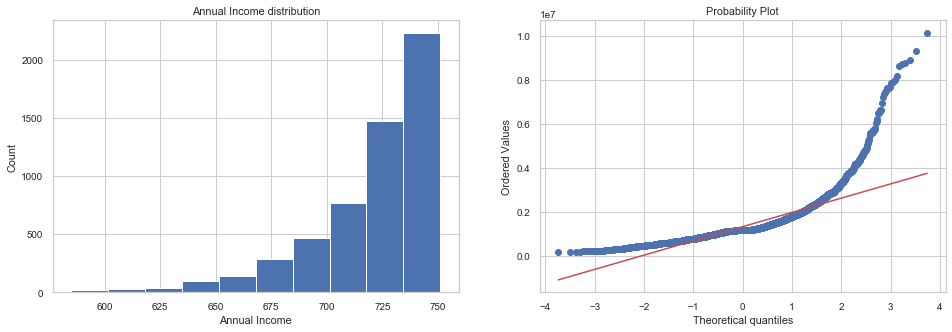

In [1126]:
plt.figure(figsize=(16, 5))

ax1 = plt.subplot(121)
ax1.set_xlabel('Annual Income')
ax1.set_ylabel('Count')
ax1.set_title('Annual Income distribution')
credit_score.hist()

ax2 = plt.subplot(122)
probplot(annual_income, dist='norm', plot=plt)

Визуальная оценка подтверждает показания критерия Шапиро-Уилка по поводу того, что закон распределения отличный от "нормального", в связи с чем, мы не сможем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака 'Annual Income' в группах с просроченным и непросроченным платежом в следующем месяце, но мы сможем воспользоваться его непараметрическим аналогом - критерием Манна-Уитни, который не требователен к закону распределения.

*Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни*

In [1127]:
mannwhitneyu(annual_income_target_0, annual_income_target_1)

MannwhitneyuResult(statistic=5045320.0, pvalue=9.37122391102781e-15)

Значение p-value меньше 0.05, следовательно гипотеза о равности математических ожиданий отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

*Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их*

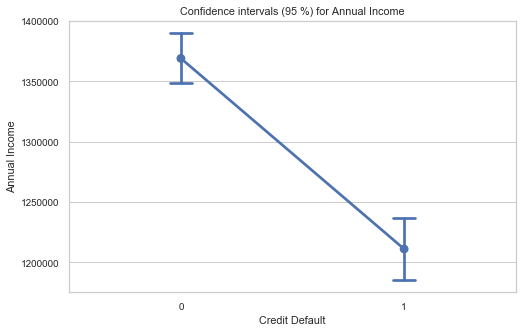

In [1128]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Annual Income', data=annual_income_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Annual Income')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

#### Оценка признака "Credit_Score_Net" в разрезе целевой переменной

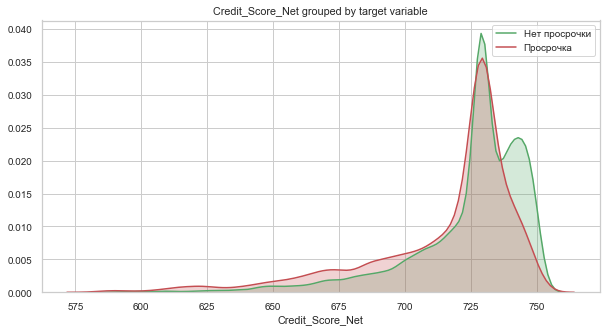

In [1129]:
credit_score_net_with_target = train_df[['Credit_Score_Net', TARGET_NAME]]
credit_score_net = credit_score_net_with_target['Credit_Score_Net']
credit_score_net_target_0 = credit_score_net[credit_score_net_with_target[TARGET_NAME] == 0]
credit_score_net_target_1 = credit_score_net[credit_score_net_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(credit_score_net_target_0, shade=True, label='Нет просрочки', color='g')
sns.kdeplot(credit_score_net_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Credit_Score_Net')
plt.title('Credit_Score_Net grouped by target variable')
plt.show()

**Наблюдение**

Похоже что две группы, полученные в результате разбиения признака "Credit_Score_Net" по целевой переменной, имеют различные распределения, что может помочь при построение модели, т.к. это будет означать, что между признаком "Credit_Score_Net" и целевой переменной, возможно, существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест) и его аналоги
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Что бы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет равенства средних значений.
Если вероятность того, что мат. ожидания в исходных группах равны, при данных выборках, будет менее 5%, то можно будет говорить о том, что скорее всего выборки имеют различные распределения.

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка*

In [1130]:
shapiro(credit_score_net)

(0.8110946416854858, 0.0)

По полученному значению p-value, которое сильно меньше 0.05, можем заключить, что гипотеза о "нормальности" отвергается.

*Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график*

((array([-3.73889526, -3.50968086, -3.3836472 , ...,  3.3836472 ,
          3.50968086,  3.73889526]),
  array([585., 586., 588., ..., 751., 751., 751.])),
 (22.657381770832988, 721.9373333333333, 0.9006239844662169))

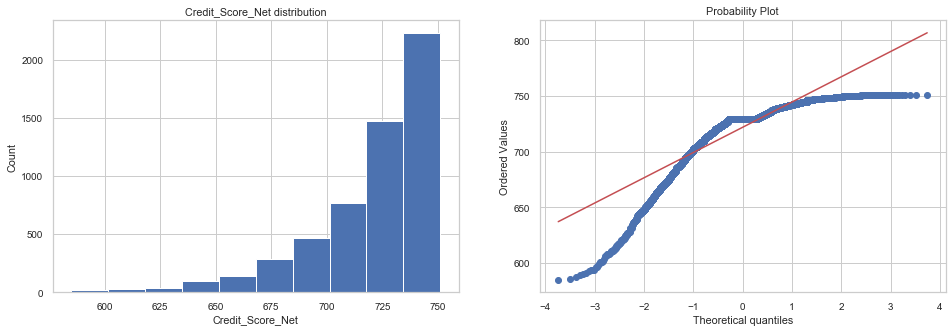

In [1131]:
plt.figure(figsize=(16, 5))

ax1 = plt.subplot(121)
ax1.set_xlabel('Credit_Score_Net')
ax1.set_ylabel('Count')
ax1.set_title('Credit_Score_Net distribution')
credit_score.hist()

ax2 = plt.subplot(122)
probplot(credit_score_net, dist='norm', plot=plt)

Визуальная оценка подтверждает показания критерия Шапиро-Уилка по поводу того, что закон распределения отличный от "нормального", в связи с чем, мы не сможем воспользоваться критерием Стьюдента для проверки гипотезы о равности мат. ожиданий признака 'Credit_Score_Net' в группах с просроченным и непросроченным платежом в следующем месяце, но мы сможем воспользоваться его непараметрическим аналогом - критерием Манна-Уитни, который не требователен к закону распределения.

*Оценим эквивалентность мат. ожадиний, в исследуемых группах, с помощью критерия Манна-Уитни*

In [1132]:
mannwhitneyu(credit_score_net_target_0, credit_score_net_target_1)

MannwhitneyuResult(statistic=4418757.0, pvalue=2.84109728423371e-52)

Значение p-value меньше 0.05, следовательно гипотеза о равности математических ожиданий отвергается, но стоит ради дополнительной проверки обратиться к доверительным интервалам.

*Построим доверительные интервалы для средних значений, каждой из двух групп и сравним их*

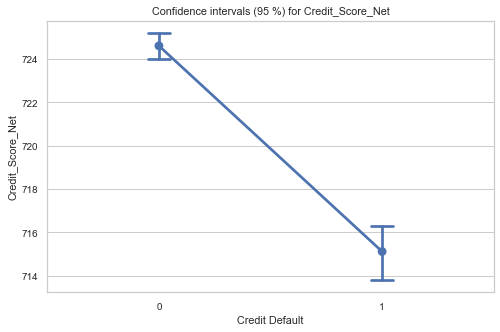

In [1133]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Credit_Score_Net', data=credit_score_net_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit_Score_Net')
plt.show()

По данному графику так же видно, что интервалы, в которых с 95% вероятностью должны находится истинные мат. ожидания этих двух групп, не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

### Анализ признакового пространства

#### Матрица корреляций

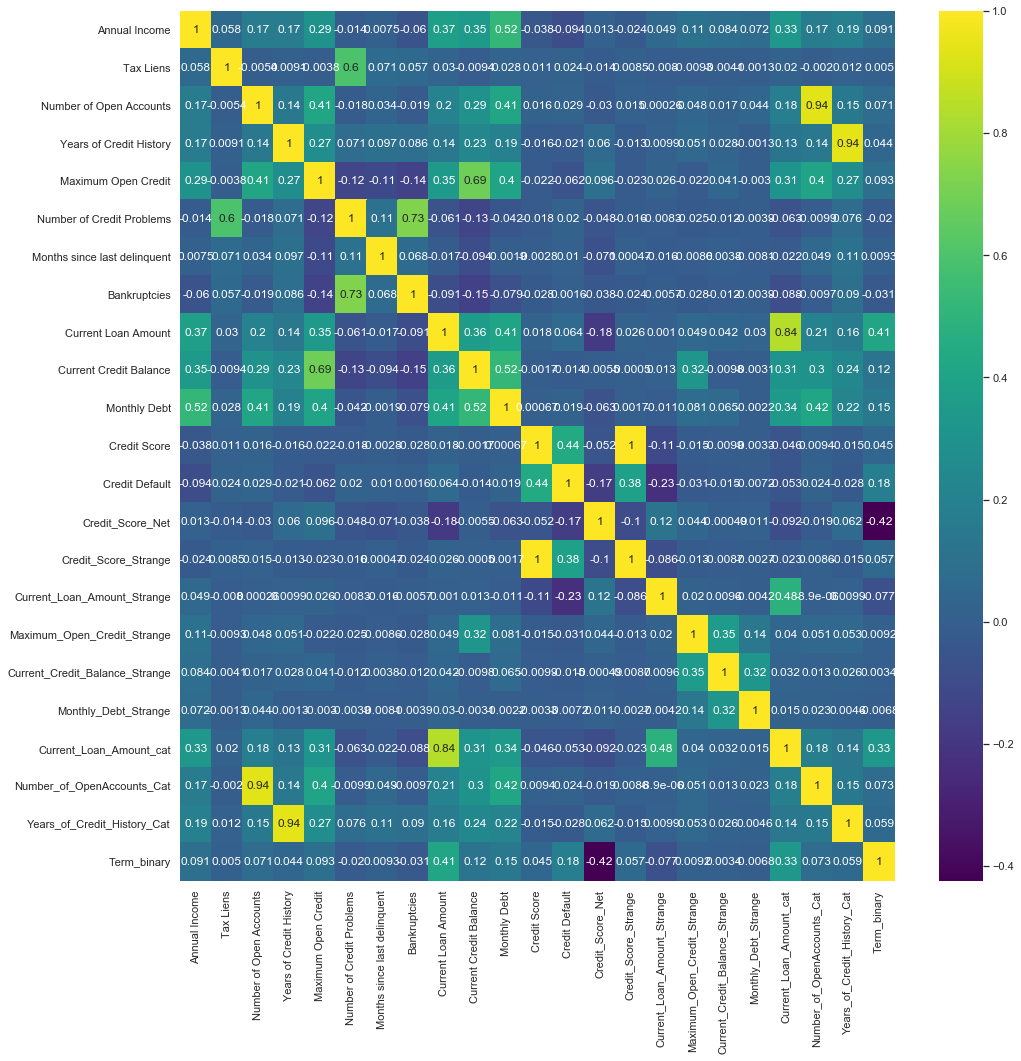

In [1134]:
sns.set(style="whitegrid", font_scale=1)

f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(train_df.corr(), cmap= 'viridis', annot=True)

### Нормализация данных

In [1135]:
scaler = StandardScaler()

norm_df = train_df.copy()
norm_df[NUM_FEATURE_NAMES] = scaler.fit_transform(norm_df[NUM_FEATURE_NAMES])

train_df = norm_df.copy()

# Сохранение модели для нормализации данных
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

### Подготовка для catboost

In [1136]:
SELECTED_FEATURE_NAMES = BASE_FEATURE_NAMES + ['Credit_Score_Strange', 'Current_Loan_Amount_Strange', 'Term_binary']

In [1137]:
train_df[SELECTED_FEATURE_NAMES].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   object 
 3   Tax Liens                     7500 non-null   int32  
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   int32  
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   int32  
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [1138]:
# Приведем категориальные признаки к типу object.

for colname in ['Tax Liens', 'Number of Credit Problems', 'Credit_Score_Strange',
                'Current_Loan_Amount_Strange', 'Term_binary']:
    train_df[colname] = train_df[colname].astype(str)
    test_df[colname] = test_df[colname].astype(str)

#### Разбиение обучающего датасета на train и test

In [1139]:
X = train_df[SELECTED_FEATURE_NAMES]
y = train_df[TARGET_NAME]

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Tax Liens',
                    'Number of Credit Problems', 'Purpose', 'Term', 
                     'Credit_Score_Strange', 'Current_Loan_Amount_Strange', 'Term_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

### Выбор лучшей модели и подбор гиперпараметров

#### Определение максимального количества уникальных значений среди категориальных признаков

In [1140]:
sorted([X_train[CAT_FEATURE_NAMES][col].nunique() for col in CAT_FEATURE_NAMES])[-1]

15

Возьмем с запасом - 20

#### Определение гиперпараметров

Константные параметры:

- eval_metric='F1' метрика
- auto_class_weights='Balanced' автоматический подбор весов для балансировки классов
- silent=True блокирование лишнего вывода логов
- cat_features=feature_names_cat категориальные признаки
- one_hot_max_size=20 - определяли выше
- early_stopping_rounds=50 - отслеживание переобучения
- boosting_type='Ordered' - дает лучше результат на небольших датасетах

Подбираемые параметры:

- depth
- learning_rate
- iterations
- bagging_temperature

In [1141]:
train_pool = Pool(
    X_train,
    y_train,
    cat_features=CAT_FEATURE_NAMES
)

test_pool = Pool(
    X_test,
    y_test,
    cat_features=CAT_FEATURE_NAMES
) 

frozen_params = {
    'eval_metric': 'F1',
    'auto_class_weights': 'Balanced',
    'silent': True,
    'one_hot_max_size': 20,
    'early_stopping_rounds': 50,
    'boosting_type': 'Ordered',
    'allow_writing_files': False
}

##### Код определения гиперпараметров

In [1142]:
%%time

model_catb = CatBoostClassifier(**frozen_params)

params_grid = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.03, 0.1, 0.3, 0.5],
    'iterations': [100, 200, 400],
    'l2_leaf_reg': [2, 2.5, 3, 3.5, 4],
    'bagging_temperature': [1, 1.5, 2]
}

gs = model_catb.randomized_search(
    params_grid,
    train_pool,
    n_iter=20,
    shuffle=True,
    stratified=True,
    partition_random_seed=42,
    cv=5
)

gs

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6799229003
bestIteration = 2

0:	loss: 0.6799229	best: 0.6799229 (0)	total: 850ms	remaining: 16.2s

bestTest = 0.6623295498
bestIteration = 95

1:	loss: 0.6623295	best: 0.6799229 (0)	total: 6s	remaining: 54s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.663690195
bestIteration = 6

2:	loss: 0.6636902	best: 0.6799229 (0)	total: 8.45s	remaining: 47.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7026967022
bestIteration = 19

3:	loss: 0.7026967	best: 0.7026967 (3)	total: 11.7s	remaining: 46.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6824160649
bestIteration = 54

4:	loss: 0.6824161	best: 0.7026967 (3)	total: 16.6s	remaining: 49.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6732240525
bestIteration = 44

5:	loss: 0.6732241	best: 0.7026967 (3)	total: 28.1s	remaining: 1m 5s
Stopped by overfitting detector  (50 iterations wait)


{'params': {'depth': 4,
  'iterations': 400,
  'bagging_temperature': 1.5,
  'learning_rate': 0.1,
  'l2_leaf_reg': 2.5},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
     

**Подобранные гиперпараметры**

  'bagging_temperature': 1.5,
  
  'depth': 4,
  
  'l2_leaf_reg': 2.5,
  
  'iterations': 400,
  
  'learning_rate': 0.1

### Обучение и оценка финальной модели

In [1143]:
%%time

final_model = CatBoostClassifier(
    **frozen_params,
    depth=4,
    iterations=400,
    learning_rate=0.1,
    l2_leaf_reg=2.5,
    bagging_temperature=1.5
)

final_model.fit(train_pool, eval_set=test_pool)

Wall time: 1.26 s


#### Результаты

In [1144]:
%%time

evaluate_preds(final_model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.76      0.81      3771
           1       0.53      0.70      0.60      1479

    accuracy                           0.74      5250
   macro avg       0.70      0.73      0.71      5250
weighted avg       0.77      0.74      0.75      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.73      0.78      1616
           1       0.47      0.62      0.54       634

    accuracy                           0.70      2250
   macro avg       0.65      0.67      0.66      2250
weighted avg       0.73      0.70      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1180  436
1                242  392
Wall time: 115 ms


#### Веса признаков

In [1145]:
feature_importances = pd.DataFrame(
    zip(X.columns, final_model.get_feature_importance()),
    columns=['feature_name', 'importance']
)

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(20)

,feature_name,importance
17,Current_Loan_Amount_Strange,36.374498
16,Credit_Score_Strange,31.659999
15,Credit Score,20.623512
1,Annual Income,1.936982
18,Term_binary,1.570125
6,Maximum Open Credit,1.213066
14,Monthly Debt,0.861127
5,Years of Credit History,0.764090
11,Term,0.753781
4,Number of Open Accounts,0.743081


### Прогнозирование на тестовом датасете

In [1146]:
df_for_model = test_df[SELECTED_FEATURE_NAMES]

y_pred_output = final_model.predict(df_for_model)

preds = pd.DataFrame()
preds['Id'] = df_for_model.index
preds['Credit Default'] = y_pred_output

preds = pd.DataFrame({'Id': np.arange(0,y_pred_output.shape[0]), 'Credit Default': y_pred_output})
preds.to_csv('106_Course_predictions.csv', index=False, encoding='utf-8', sep=',')
preds.tail()

,Id,Credit Default
2495,2495,0
2496,2496,1
2497,2497,1
2498,2498,1
2499,2499,1
